In [11]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [12]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [13]:
IN_DIR = "D:\\result\\20221027\\"
OUT_DIR = "D:\\result\\20221027\\"
sub_dir_list = "cbi_q_20\\1\\"

In [14]:
time_table = pd.read_csv("time.csv", header=None, index_col=0)
time_table = time_table.values[1, :33].astype(np.int)

In [15]:
ptv_result = np.zeros((1, 4))

In [16]:
for t in range(1, 11):
    for i in tqdm(range(t, 10900, 10)):
        for j in range(16):
            if time_table[2 * j] <= i < time_table[2 * j + 1] or time_table[32] <= i:
                try:
                    r = np.loadtxt(OUT_DIR + "ptv\\" + sub_dir_list + f"pp_{i}.csv", delimiter=',', skiprows=1)
                except StopIteration:
                    r = None
                except OSError:
                    r = None

                if r is None:
                    pass
                elif r.ndim == 1:
                    if len(r) > 0:
                        r = r[np.newaxis, :]
                        ptv_result = np.vstack([ptv_result, r])

                elif r.ndim == 2:
                    ptv_result = np.vstack([ptv_result, r])

100%|██████████| 1089/1089 [00:15<00:00, 70.55it/s] 


In [17]:
ptv_result = pd.DataFrame(ptv_result, columns=['x', 'y', 'dx', 'dy'])
for row in ptv_result.index:
    if (ptv_result.loc[row] == 0).all():
        ptv_result.drop(row, axis=0, inplace=True)

In [18]:
ptv_result['x'] = ptv_result['x'] - 498
ptv_result['y'] = 51 - ptv_result['y']
ptv_result['dy'] = - ptv_result['dy']

In [19]:
ptv_result['dr'] = np.sqrt(ptv_result['dx']**2 + ptv_result['dy']**2)

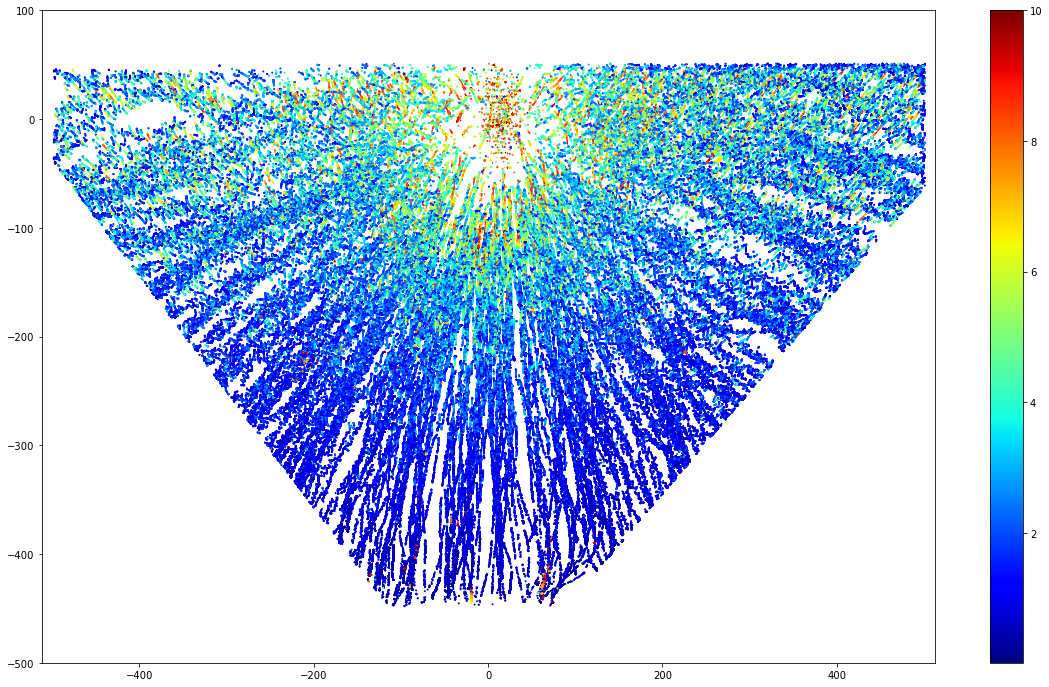

In [20]:
fig, ax = plt.subplots(figsize=(20, 12))
plt.xlim(-512, 512)
plt.ylim(-500, 100)
c = ax.quiver(ptv_result['x'], ptv_result['y'], ptv_result['dx'], ptv_result['dy'], ptv_result['dr'], cmap="jet")
fig.colorbar(c)
plt.show()

In [21]:
with open(f'ptv_cbi_q_20.pickle', mode='wb') as fp:
    pickle.dump(ptv_result, fp)